在开始之前，先明确一下我们的目标是什么，同时对提供的信息做一些简单的分析  
> Competition Description  
> ...  
> **One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. **...      
>  In this challenge, **we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.**  

根据 Competition Description 我们可以得到哪些结论呢?  
1. 造成大规模死亡很大的原因是因为没有足够的救生艇  
2. 本次的目标是根据船上乘客/船员的特征判断是否能够生存  

OK，接下来让我们看一下数据集中有哪些有用的信息  

首先，让我们看一下数据中有哪些属性，以及这些属性可能的值有哪些  
下面的表格我们可以从[这里](https://www.kaggle.com/c/titanic/data)得到  

| variables | definition | key |  
|-----------|------------|-----|
| Survival | 是否生存| 0 = No, 1 = Yes |  
| Pclass  | 社会地位 | 1 = 1st, 2 = 2nd, 3 = 3rd |  
| Sex	| 性别 |  |  
| Age	| 年龄 |  |  
| SibSp | 船上兄弟姐妹及配偶的数目	|  |  
| Parch | 船上父母的数目及子辈的数目 |  |  
| Ticket | 票号 | |  
| Fare | 费用 | |  
| Cabin | 船舱号 | |  
| Embarked | 上船的位置 | C = Cherbourg, Q = Queenstown, S = Southampton |  

从上面的表格中我们可以知道每个数据属性的具体含义，这个时候我们可以做出以下不负责任的假设了 ~  
1. Pclass 越高 Survival 的可能性越大  
2. Sex 为 female 的 Survival 的可能性越大  
3. Age 处在`儿童`以及`老人`阶段的 Survival 的可能性越大  
4. SibSp 越大的 Survival 的可能性越小  
5. Parch 越大的 Survival 的可能性越小  
6. Fare 越高的 Survial 的可能性越小  
7. Cabin 代表的客舱位置越高的 Survival 的可能性越小  
8. Embarked 感觉上和 Survival 可能性应该没什么关系  

接下来，我们导入数据集并看看数据集长什么样子

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer
from sklearn.feature_extraction import DictVectorizer


data_train = pd.read_csv('../input/train.csv')
data_test = pd.read_csv('../input/test.csv')
print('training data shape: ', data_train.shape)
data_train.sample(10)

training data shape:  (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
434,435,0,1,"Silvey, Mr. William Baird",male,50.0,1,0,13507,55.9000,E44,S
491,492,0,3,"Windelov, Mr. Einar",male,21.0,0,0,SOTON/OQ 3101317,7.2500,NaN,S
325,326,1,1,"Young, Miss. Marie Grice",female,36.0,0,0,PC 17760,135.6333,C32,C
738,739,0,3,"Ivanoff, Mr. Kanio",male,NaN,0,0,349201,7.8958,NaN,S
746,747,0,3,"Abbott, Mr. Rossmore Edward",male,16.0,1,1,C.A. 2673,20.2500,NaN,S
546,547,1,2,"Beane, Mrs. Edward (Ethel Clarke)",female,19.0,1,0,2908,26.0000,NaN,S
422,423,0,3,"Zimmerman, Mr. Leo",male,29.0,0,0,315082,7.8750,NaN,S
728,729,0,2,"Bryhl, Mr. Kurt Arnold Gottfrid",male,25.0,1,0,236853,26.0000,NaN,S
780,781,1,3,"Ayoub, Miss. Banoura",female,13.0,0,0,2687,7.2292,NaN,C
736,737,0,3,"Ford, Mrs. Edward (Margaret Ann Watson)",female,48.0,1,3,W./C. 6608,34.3750,NaN,S


啊咧咧，看着这个表格，我们能得到很多关于数据的信息  
1. Name 我们无法直接利用，但是 Name 格式是 ?Name + 称谓 + ?Name 的形式，感觉上可以和 Sex 扯上点关系  
2. Age 中有 NaN，需要处理一下，同时 Age 是浮点值  
3. SibSp 和 Parch 为整数  
4. Ticket 看起来没什么规律，和其他属性也没什么显而易见的关联，drop 掉  
5. Cabin 有可能是空值，看起来只是一串字符串，形式应该是 \[CabinPrefix\]\[CabinNumber\]    

直观上得到的结论有这些，接下来，让我们用代码做更进一步的验证  

In [2]:
print('= ' * 20 + 'Check is data contain nan value' + ' =' * 20)
def get_contain_nan_columns(data):
    return [column for column in data.columns if data[column].isna().any()]
columns_contain_nan = get_contain_nan_columns(data_train)
print('Columns contain nan value: ', columns_contain_nan)
print('= = ' * 20)
def print_columns_value_counts(data, columns_ignored=['PassengerId', 'Sex', 'Survived', 'Pclass']):
    _data = data.drop(columns_ignored, axis=1)
    for column in _data.columns:
        value_counts = data_train[column].value_counts(dropna=True)
        print('Value Counts Of ', column)
        print(value_counts.sample(value_counts.shape[0] if value_counts.shape[0] < 30 else 30))
        print('= = ' * 20)
print_columns_value_counts(data_train)


= = = = = = = = = = = = = = = = = = = = Check is data contain nan value = = = = = = = = = = = = = = = = = = = =
Columns contain nan value:  ['Age', 'Cabin', 'Embarked']
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Value Counts Of  Name
Artagaveytia, Mr. Ramon                                                               1
Hold, Mr. Stephen                                                                     1
Baumann, Mr. John D                                                                   1
Youseff, Mr. Gerious                                                                  1
Maioni, Miss. Roberta                                                                 1
Slayter, Miss. Hilda Mary                                                             1
Canavan, Miss. Mary                                                                   1
Givard, Mr. Hans Kristensen                                                           1
McGowan, Miss. Anna "Ann

从上面的结果中我们可以看到，需要处理 NaN 值的属性有 Age, Cabin, Embarked  
对于 Name 这个属性，表面上看起来是各不相同的，但是我们从这些名字中的称谓可以推测出乘客的大致年龄段，从而更好的处理缺失的 Age 值  
另外，对于 Cabin，除了包含特殊的 NaN 值，我们还能发现 Cabin 的值的形式有可能是 `C23 C25 C27`  


In [3]:
special_cabin_value = 'C23 C25 C27'
data_train.loc[data_train['Cabin'] == special_cabin_value]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0,C23 C25 C27,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0,C23 C25 C27,S
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0,C23 C25 C27,S


利用上面的代码，我们找到了拥有相同 Special Cabin 值的乘客，我们看到了什么？这些乘客看起来像是一家人！  
但是，是不是少了什么？这几位乘客的家人似乎有一位的 Cabin 不是 Special Cabin，让我们用他们的名字特征再来找找看  

In [4]:
special_name_lastname = 'Fortune'
print('= = ' * 20)
print(data_train.loc[data_train['Name'].str.startswith(special_name_lastname)].describe())
print('= = ' * 20)
print(data_train.loc[data_train['Ticket'] == '19950'].describe())

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
       PassengerId  Survived  Pclass        Age  SibSp  Parch   Fare
count     4.000000   4.00000     4.0   4.000000    4.0    4.0    4.0
mean    224.500000   0.50000     1.0  32.500000    2.5    2.5  263.0
std     197.306023   0.57735     0.0  21.110819    1.0    1.0    0.0
min      28.000000   0.00000     1.0  19.000000    1.0    2.0  263.0
25%      73.750000   0.00000     1.0  22.000000    2.5    2.0  263.0
50%     215.500000   0.50000     1.0  23.500000    3.0    2.0  263.0
75%     366.250000   1.00000     1.0  34.000000    3.0    2.5  263.0
max     439.000000   1.00000     1.0  64.000000    3.0    4.0  263.0
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
       PassengerId  Survived  Pclass        Age  SibSp  Parch   Fare
count     4.000000   4.00000     4.0   4.000000    4.0    4.0    4.0
mean    224.500000   0.50000     1.0  32.500000    2.5    2.5  263.0
std     19

，，，头疼，看起来似乎真的没有办法利用利用这些信息找到哪位不见的家人了，，，  
通过上面的分析，我们可以又可以作出一些决定了：  
1. Canbin 只需要保留开头的字母用来确认船舱类型  
2. Name 只需要保留中间的称谓部分  
4. SibSp & Parch 值是确定的，不需要特殊处理  
5. Embarked 没什么用，drop 掉  
6. Age & Fare 为 float64  
在开始行动之前，让我们看一下这些属性之间的关系  


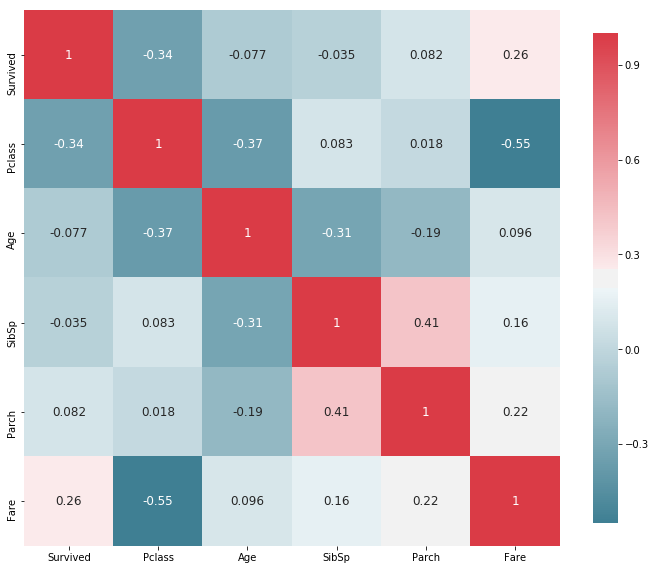

In [5]:
def plot_correlation_map(data):
    corr = data.corr()
    _ , ax = plt.subplots(figsize =(12, 10))
    cmap = sns.diverging_palette(220, 10, as_cmap = True)
    _ = sns.heatmap(corr, cmap=cmap, ax=ax, cbar_kws={'shrink': .9}, annot_kws={'fontsize': 12}, annot=True,square=True)
plot_correlation_map(data_train.drop(['PassengerId'], axis=1))

从上面的图中我们可以看到哪些信息呢？  
首先，从图中看和 Survival 关系比较密切的是 Fare 和 Pclass  
然后，从图中还能看到，Fare 和 Pclass，SibSp 和 Parch，Fare 和 SibSp & Parch 的关系也比较密切  
Fare 和 Pclass 关系密切很清楚，为什么 Fare 和 SibSp 以及 Parch 的关系也会那么密切呢？  
在之前的我们查看了一家人的数据，一家人的 Fare 都是一样的，因此我们可以认为，在数据中，家庭中每个人的 Fare 实际上是 Fare / FamilySize  
因此，我们需要做的处理有：  
1. 将 SibSp + Parch => FamilySize  
2. 将每个人的 Fare / FamilySize => Fare  
接下来，综合前面的分析，对数据进行初步处理  

In [6]:
def extract_name_title(name_column):
    return name_column.apply(lambda name: re.findall(r'.+, (\w+). .+', name)[0])

def update_nan_age(data, target_index=5, title_index=-2):
    data_name_title_group = data.groupby('NameTitle')
    data_copied = pd.DataFrame.copy(data)
    for v in data_copied.values:
        mean_age = data_name_title_group.get_group(v[title_index]).Age.mean()
        
        if pd.isna(v[target_index]) or pd.isnull(v)[target_index]:
            data_copied.loc[data_copied.PassengerId == v[0], 'Age'] = 0 if pd.isna(mean_age) else mean_age
    return data_copied

def convert_sex(sex_column):
    sex_map = {'male': 0, 'female': 1}
    return sex_column.apply(lambda sex: sex_map[sex])

def update_nan_cabin(data, target_index=10, pclass_index=2):
    data_copied = pd.DataFrame.copy(data)
    pclass_group = data_copied.groupby('Pclass')
    cabin_map = {key: index for index, key in enumerate('ABCDEFGHIJKLMNOPQRSTUVWXYZ')}
    data_copied.Cabin = data_copied.Cabin.apply(lambda cabin: cabin if pd.isna(cabin) else cabin_map[cabin[0]])
    for v in data_copied.values:
#         print('MOST CABIN: ', pclass_group.get_group(v[pclass_index]).Cabin.value_counts().max())
        if pd.isna(v[target_index]) or pd.isnull(v)[target_index]:
            data_copied.loc[data_copied.PassengerId == v[0], 'Cabin'] = pclass_group.get_group(v[pclass_index]).Cabin.value_counts().max()
    return data_copied

def convert_family_size(data):
    return data.SibSp + data.Parch

def drop_unnecessary(data):
    return data.drop(['Ticket', 'Embarked', 'Name', 'NameTitle', 'SibSp', 'Parch'], axis=1)

data_train['NameTitle'] = extract_name_title(data_train.Name)
data_train['FamilySize'] = convert_family_size(data_train)
data_train['Sex'] = convert_sex(data_train.Sex)
data_train.Fare = data_train.Fare.fillna(data_train.Fare.mean())
data_train = update_nan_age(data_train)
data_train = update_nan_cabin(data_train)
X_train = drop_unnecessary(data_train)

In [7]:
X_train = X_train.drop(['PassengerId', 'Survived'], axis=1)
y_train = data_train.Survived
model = RandomForestClassifier()
model.fit(X_train, y_train)
from sklearn.model_selection import cross_val_score 
cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

array([0.73743017, 0.79329609, 0.85955056, 0.8258427 , 0.85875706])

In [8]:
data_test['NameTitle'] = extract_name_title(data_test.Name)
data_test['FamilySize'] = convert_family_size(data_test)
data_test['Sex'] = convert_sex(data_test.Sex)
data_test.Fare = data_test.Fare.fillna(data_test.Fare.mean())
data_test = update_nan_age(data_test, 4)
data_test = update_nan_cabin(data_test, 9, 1)
data_test = drop_unnecessary(data_test)
X_test = data_test.drop(['PassengerId'], axis=1)
print(X_test.columns, X_test.shape, X_train.columns, X_train.shape)
prediction = model.predict(X_test)

first_submission = pd.DataFrame({
    "PassengerId": data_test["PassengerId"],
    "Survived": prediction
})
first_submission.to_csv('second_submission.csv', index=False)

Index(['Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'FamilySize'], dtype='object') (418, 6) Index(['Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'FamilySize'], dtype='object') (891, 6)


In [9]:

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer
from sklearn.feature_extraction import DictVectorizer
data_train = pd.read_csv('../input/train.csv')
data_test = pd.read_csv('../input/test.csv')

def convert_sex_to_numerical(sex): 
    dic = {'male': 0, 'female': 1}
    return dic.get(sex, None)

def convert_cabin_to_numerical(cabin):
    import re
    dic = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
    pat = re.compile(r'(\w)\d+')
    if pd.isna(cabin): return cabin
    prefix = re.findall(pat, cabin)
    if len(prefix):
        return dic[prefix[0]]

def convert_embarked_to_numerical(embarked):
    dic = {'S': 0, 'C': 1, 'Q': 2}
    return dic.get(embarked, None)

def process_trainning_data(data):
    X = data.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
    X['FamilySize'] = X['SibSp'] + X['Parch']
    X = X.drop(['SibSp', 'Parch'], axis=1)
    X.Sex = X.Sex.apply(convert_sex_to_numerical)
    X.Cabin = X.Cabin.apply(convert_cabin_to_numerical)
    X.Embarked = X.Embarked.apply(convert_embarked_to_numerical)
    return X

y_train = data_train.Survived
X_train = process_trainning_data(data_train)
X_train.drop(['Survived'], axis=1, inplace=True)
imputer = Imputer()
X_train = imputer.fit_transform(X_train)
X_test = process_trainning_data(data_test)
X_test = imputer.transform(X_test)

model = RandomForestClassifier()
model.fit(X_train, y_train)
prediction = model.predict(X_test)
first_submission = pd.DataFrame({
    "PassengerId": data_test["PassengerId"],
    "Survived": prediction
})
first_submission.to_csv('first_submission.csv', index=False)

0 A
1 B
2 C
3 D
4 E
5 F
6 G
7 H
8 I
9 J
10 K
11 L
12 M
13 N
14 O
15 P
16 Q
17 R
18 S
19 T
20 U
21 V
22 W
23 X
24 Y
25 Z
[0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0
 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0
 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0
 1 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0
 0 1 1 1 1 0 0 1 0 0 0]
